In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import os
from functools import partial, reduce
import time
import requests
from io import StringIO

os.chdir('C:\\Users\\Usuario\\Desktop\\research\\PAN\\PAN_TOTAL\\')
#puedes descargar la base de datos desde:
#https://datosabiertos.mef.gob.pe/dataset/clasificacion-funcional-del-gasto

In [ ]:
def get_data_bcrp(Code, StartDate, EndDate, Freq, ColName):
    content_var = requests.get("https://estadisticas.bcrp.gob.pe/estadisticas/series/api/" + Code + "/csv/" + StartDate + "/" + EndDate,
                               verify = False).text.replace("<br>","\n").strip()
    csv_var     = StringIO(content_var)
    df          = pd.read_csv(csv_var)

    if Freq == 'Q': # to data in quarterly frequency
        StartDate_mod = StartDate.split('-')[0] + '-' + str( (int(StartDate.split('-')[-1]))*2 + int(StartDate.split('-')[-1]))
        df.index      = pd.date_range(start = StartDate_mod, freq = Freq, periods = len(df))
        df            = df.drop(df.columns[0],axis=1); df.columns  = [ColName]
    else: # to data in monthly frequency
        df.index      = pd.date_range(start = StartDate, freq = Freq, periods = len(df))
        df            = df.drop(df.columns[0],axis=1); df.columns  = [ColName]

    return df

def get_ubigeo(df,column_df):
    x_store      = ['nan']*len(df)
    x            = list(df[column_df])
    for i in np.arange(0,len(df)):
        if len(str(x[i])) == 1:
            x_store[i] = '0' + str(x[i])
        else:
            x_store[i] = str(x[i])
    return x_store


def pct_change_list(a):
    return [((a[i]-a[i-1])/a[i-1])*100 for i in range(1, len(a))]


def mean_list(a):
    return [(a[i]+a[i-1])/2 for i in range(1, len(a))]


In [ ]:
pop = pd.read_excel('poblacion_distri.xlsx', usecols=['cod_distr','total'] )
pop = pop.set_axis( ['UBIGEO','pop'], axis=1, inplace=False).reset_index(drop=True)
pop['UBIGEO'] = pop['UBIGEO'].astype(str)

for i in range(len(pop)):
    if len(pop.iloc[i, 0]) == 5:
        pop.iloc[i, 0] = '0' + pop.iloc[i, 0]
    else:
        pop.iloc[i, 0] = pop.iloc[i, 0]


In [ ]:
start_year = 2017
end_year   = 2023

use_cols = ['MES_EJE','NIVEL_GOBIERNO','DEPARTAMENTO_EJECUTORA','PROVINCIA_EJECUTORA','DISTRITO_EJECUTORA',
            'PRODUCTO_PROYECTO_NOMBRE','PRODUCTO_PROYECTO',
            'PROGRAMA_PPTO_NOMBRE','GRUPO_FUNCIONAL_NOMBRE', 'CATEGORIA_GASTO_NOMBRE',
            'MONTO_PIM','MONTO_DEVENGADO']


mean_store = [] #mean_store contiene 3 tipos de devengado a nivel MUNICIPAL
#1.Devengado total.
#2.Devengado solo por gasto corriente.
#3.Devegando por grupo funcional excluido INFRAESTRUCTURA Y EQUIPAMIENTO.
gf_store   = [] # grupo funcional
cg_store   = [] # categoria de gasto
me_store   = [] # mes de ejecucion
mean_vars  = ['UBIGEO','MES_EJE','NIVEL_GOBIERNO','GRUPO_FUNCIONAL_NOMBRE','CATEGORIA_GASTO_NOMBRE',
              'PRODUCTO_PROYECTO_NOMBRE','PRODUCTO_PROYECTO',
              'MONTO_PIM','MONTO_DEVENGADO']


for year in np.arange(start_year,end_year,1):
    start = time.time()
    print(f"Running year {year} ... ")
    gasto_x     = pd.read_csv( str(year) +'-Gasto.csv' , usecols = use_cols , encoding='utf-8')
    gasto_x_red = gasto_x[(gasto_x['PROGRAMA_PPTO_NOMBRE'] == "PROGRAMA ARTICULADO NUTRICIONAL")]

    ##Obtener las medidas importantes del gasto PAN, son 15: la categoria 3 del producto proyecto

    ################################################################################################
    ################################## DATOS A NIVEL DE GOBIERNO  ###################################
    ################################## CENTRAL-REGIONAL-MUNICIPAL ##################################
    ################################################################################################

    store_ubs = []
    for ii in ['DEPARTAMENTO_EJECUTORA','PROVINCIA_EJECUTORA','DISTRITO_EJECUTORA'] :
        store_ubs.append(get_ubigeo(gasto_x_red,ii))
    ubigeo = list(reduce(partial(map, str.__add__), store_ubs ))

    df     = pd.concat([pd.DataFrame(ubigeo, columns=['UBIGEO']), gasto_x_red.reset_index(drop=True)], axis=1)
    df_slc = df[mean_vars]

    ######### Resultado 1: Descomposicion del gasto PAN por grupo funcional
    gf = df_slc[['GRUPO_FUNCIONAL_NOMBRE','MONTO_DEVENGADO']].groupby('GRUPO_FUNCIONAL_NOMBRE').sum().reset_index()
    gf = gf.set_index('GRUPO_FUNCIONAL_NOMBRE').add_suffix('_' + str(year)[2:4])
    gf_store.append(gf)

    ######### Resultado 2: Descomposicion del gasto PAN por categoria del gasto

    cg = df_slc[['CATEGORIA_GASTO_NOMBRE','MONTO_DEVENGADO']].groupby('CATEGORIA_GASTO_NOMBRE').sum().reset_index()
    cg = cg.set_index('CATEGORIA_GASTO_NOMBRE').add_suffix('_' + str(year)[2:4])
    cg_store.append(cg)

    ######### Resultado 3: Descomposicion del gasto PAN por mes de ejecucion
    me = df_slc[['MES_EJE','MONTO_DEVENGADO']].groupby('MES_EJE').sum().reset_index()
    me = me.set_index('MES_EJE').add_suffix('_' + str(year)[2:4])
    me_store.append(me)


    ################################################################################################
    ############################### DATOS A NIVEL DE MUNICIPALIDADES ###############################
    ################################################################################################

    ######### Resultado 4: Aplicamos los filtros a nivel municipal = M
    df_slc_m = df_slc[ (df_slc['NIVEL_GOBIERNO'] == 'M')]

    ### DIVISION DE GRUPO FUNCIONAL Y CATEGORIA DE GASTO PARA DEVENGADO A NIVEL MUNICIPAL
    print(f'GRUPO FUNCIONAL NOMBRE: \n {pd.DataFrame(df_slc_m.GRUPO_FUNCIONAL_NOMBRE.value_counts())} \n \n \n')
    print(f'CATEGORIA GASTO NOMBRE: \n {pd.DataFrame(df_slc_m.CATEGORIA_GASTO_NOMBRE.value_counts())} \n \n ')

    #Filtro 1: Monto devengado total
    filt1 = df_slc_m[['UBIGEO','MONTO_PIM','MONTO_DEVENGADO']].groupby('UBIGEO').sum().reset_index()
    #Filtro 2: Monto devengado gasto corriente
    filt2 = df_slc_m[df_slc_m.CATEGORIA_GASTO_NOMBRE=='GASTO CORRIENTE'
                        ][['UBIGEO','MONTO_PIM','MONTO_DEVENGADO']].groupby('UBIGEO').sum().reset_index()
    #Filtro 3: Monto devengado gasto para cuatro grupos funcionales:
    # 1.ATENCION MEDICA BASICA, 2.CONTROL DE RIESGOS Y DAÑOS PARA LA SALUD, 3.PLANEAMIENTO INSTITUCIONAL y
    # 4.REGULACION Y CONTROL SANITARIO
    filt3 = df_slc_m[ (df_slc_m.GRUPO_FUNCIONAL_NOMBRE != 'INFRAESTRUCTURA Y EQUIPAMIENTO')
                        ][['UBIGEO','MONTO_PIM','MONTO_DEVENGADO']].groupby('UBIGEO').sum().reset_index()

    all_filts  = [filt1,filt2,filt3]
    all_filts_2 = []
    for i_df in all_filts:
        i_df         = i_df[ (i_df['MONTO_DEVENGADO'] != 0) ].reset_index(drop=True) #mantener distritos con gasto positivo
        i_df['Avc']  = i_df['MONTO_DEVENGADO']*100/i_df['MONTO_PIM']
        i_df.drop('MONTO_PIM', axis=1, inplace=True)
        all_filts_2.append(i_df)

    suffix     = ('_total_', '_gc_', '_gf_') # total, gasto corriente, grupo funcional
    store_filt = []

    for i_df, j in zip(all_filts_2, suffix):
        store_filt.append(i_df.rename(columns={c: c + j +  str(year)[2:4] for c in i_df.columns if c not in ['UBIGEO']}))

    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['UBIGEO'],how='left'), store_filt)
    ### Mean result
    df_merged.columns = df_merged.columns.str.replace("MONTO_DEVENGADO", "Dev")
    mean_store.append(df_merged)
    stop = time.time()
    print(f"Finish year {year}, it have taken {round(stop-start,2)} seconds \n\n\n")


Running year 2017 ... 
GRUPO FUNCIONAL NOMBRE: 
                                           GRUPO_FUNCIONAL_NOMBRE
CONTROL DE RIESGOS Y DAÑOS PARA LA SALUD                   40704
INFRAESTRUCTURA Y EQUIPAMIENTO                              3493
ATENCION MEDICA BASICA                                      1517 
 
 

CATEGORIA GASTO NOMBRE: 
                   CATEGORIA_GASTO_NOMBRE
GASTO CORRIENTE                    38228
GASTO DE CAPITAL                    7486 
 
 
Finish year 2017, it have taken 73.76 seconds 



Running year 2018 ... 
GRUPO FUNCIONAL NOMBRE: 
                                           GRUPO_FUNCIONAL_NOMBRE
CONTROL DE RIESGOS Y DAÑOS PARA LA SALUD                   35547
INFRAESTRUCTURA Y EQUIPAMIENTO                              4449
ATENCION MEDICA BASICA                                      1888 
 
 

CATEGORIA GASTO NOMBRE: 
                   CATEGORIA_GASTO_NOMBRE
GASTO CORRIENTE                    33341
GASTO DE CAPITAL                    8543 
 
 
Finish year 

In [ ]:
count = 0
for ii in range(start_year,end_year):
    mean_store[count].to_excel('PAN_distrito_'+ str(ii)+'.xlsx', index=False)
    count +=1

In [ ]:
years_str = [];
for i in range(start_year,end_year,1):
    years_str.append(str(i))
years_str

['2017', '2018', '2019', '2020', '2021', '2022']

In [ ]:
## IPC lima metropolitana para alcular el gasto real:
cpi       = get_data_bcrp('PN38705PM', str(start_year) + '-01', str(end_year-1)+'-12',  'M', 'cpi')
# Consumer index prices  ----> MONTHLY FREQUENCY
cpi       = cpi.resample('A').mean()
cpi.index = years_str


C:\Users\Usuario\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'estadisticas.bcrp.gob.pe'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [ ]:

df_mean  = reduce(lambda  left,right: pd.merge(left,right,on=['UBIGEO'],how='left'), mean_store)


df_mean_outer  = reduce(lambda  left,right: pd.merge(left,right,on=['UBIGEO'],how='outer'), mean_store)


In [ ]:
df_mean.dropna().shape, df_mean.dropna().shape

((428, 37), (428, 37))

In [ ]:
df_mean_outer.shape, df_mean.shape

((1757, 37), (1194, 37))

Dev_total : length=511
Dev_gc : length=428
Dev_gf : length=461


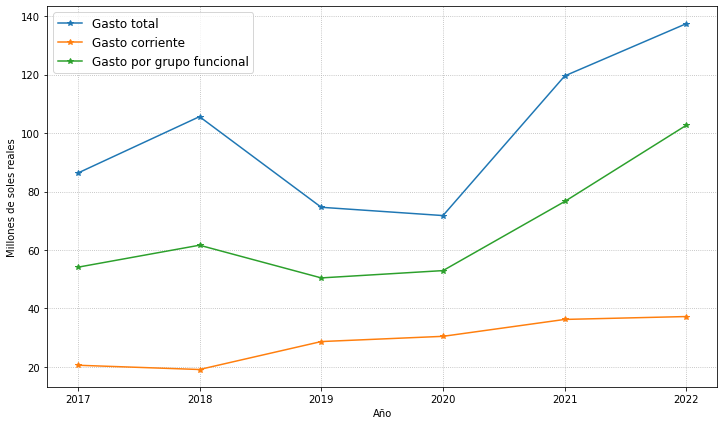

In [ ]:
store = [];
col_names = ['Dev_total' , 'Dev_gc' , 'Dev_gf']

for ii_exp in col_names:
    df_filt       = df_mean.filter(regex = ii_exp).dropna().reset_index(drop=True)
    #df_filt       = df_mean.filter(regex = ii_exp).reset_index(drop=True)
    print(f'{ii_exp} : length={df_filt.shape[0]}')
    df_filt_sum   = np.array(df_filt.sum(axis=0))
    gasto_real    = ((df_filt_sum / np.array(cpi.cpi))*100)/10**6
    df_final      = pd.DataFrame(gasto_real, index=years_str, columns=[ii_exp])

    store.append(df_final)

stats = pd.concat(store, axis=1)


labels = ['Gasto total', 'Gasto corriente', 'Gasto por grupo funcional']

fig,ax = plt.subplots(1,1, figsize=(12,7))

for ii in range(0,3):
    ax.plot(stats[col_names[ii]], label=labels[ii],marker='*')
    ax.legend(loc='best',fontsize = 12);
    ax.grid(linestyle=':');
    ax.set_ylabel('Millones de soles reales'); ax.set_xlabel('Año')

plt.show()


Dev_total : length=1757
Dev_gc : length=1757
Dev_gf : length=1757


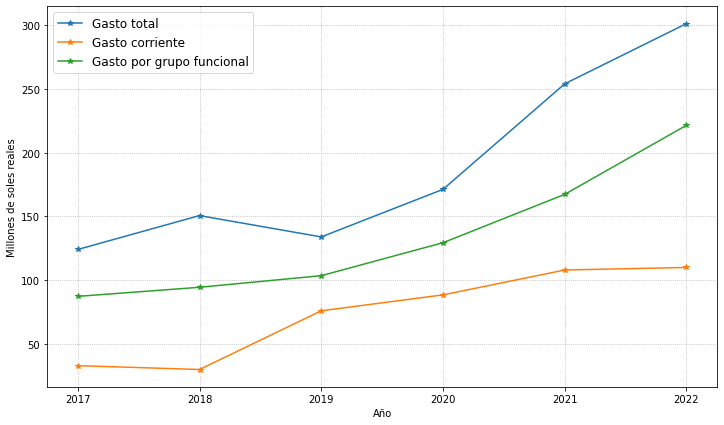

In [ ]:
## ALL MUNICIPALITIES
store     = [];
col_names = ['Dev_total' , 'Dev_gc' , 'Dev_gf']

for ii_exp in col_names:
    df_filt      = df_mean_outer.filter(regex = ii_exp).reset_index(drop=True) #filter kind of DEVENGADO
    print(f'{ii_exp} : length={df_filt.shape[0]}')
    df_filt_sum   = np.array(df_filt.sum(axis=0)) #Sumar el gasto de todas las municipalidades
    gasto_real    = ((df_filt_sum / np.array(cpi.cpi))*100)/10**6 # convertir a terminos reales y reescalar
    df_final      = pd.DataFrame(gasto_real, index=years_str, columns=[ii_exp]) #guardar en un Dataframe los resultados

    store.append(df_final)

stats = pd.concat(store, axis=1)

fig,ax = plt.subplots(1,1, figsize=(12,7))

for ii in range(0,3):
    ax.plot(stats[col_names[ii]], label=labels[ii],marker='*')
    ax.legend(loc='best',fontsize = 12);
    ax.grid(linestyle=':');
    ax.set_ylabel('Millones de soles reales'); ax.set_xlabel('Año')

plt.show()


In [ ]:
## Los tres tipos de "Devengado" real por anios 2017-2022

col_names = ['Dev_total' , 'Dev_gc' , 'Dev_gf']
store_total = []
for icol in col_names:
    df_filt       = df_mean.filter(regex = icol +'|UBIGEO').dropna().reset_index(drop=True)
    new_dataframe = df_filt.copy()
    colnames = list(new_dataframe)
    colnames.remove('UBIGEO')
    jj = 0
    for ii in colnames:
        new_dataframe[ii] = new_dataframe[ii]/np.array(cpi.iloc[jj])*100 #print(f'{ii},{jj},{np.array(cpi.iloc[jj])}')
        jj += 1

    store_total.append(new_dataframe)


In [ ]:
def custom_calc(x):
    return (((x[1] - x[0]) / x[0]) * 100).round(2)

## Los tres tipos de "Devengado" en cambios porcentuales por anios 2018-2022, se reduce un anio
col_names = ['Dev_total' , 'Dev_gc' , 'Dev_gf']

store_total2 = []
store_total3 = []
for idf in range(3):
    df = store_total[idf]

    df2 = pd.DataFrame(df.UBIGEO)
    df3 = pd.DataFrame(df.UBIGEO)
    for ii in range(1,6):
        #calcular la diferencia porcentural
        df2['diff_'+col_names[idf]+'_'+str(years_str[ii][-2:])] = df.iloc[:,ii:ii+2].apply(custom_calc, axis=1)
        print(f'{ii}:{ii+2} and {df.iloc[:,ii:ii+2].columns}')

        ## construir el instrumento:
        df3['istru_'+col_names[idf]+'_'+years_str[ii][-2:]] = [1 if x < 0  else 0 for x in df2.iloc[:,ii]]
    print('\n')
    store_total2.append(df2)
    store_total3.append(df3)

### Falta agregar el nombre


1:3 and Index(['Dev_total_17', 'Dev_total_18'], dtype='object')
2:4 and Index(['Dev_total_18', 'Dev_total_19'], dtype='object')
3:5 and Index(['Dev_total_19', 'Dev_total_20'], dtype='object')
4:6 and Index(['Dev_total_20', 'Dev_total_21'], dtype='object')
5:7 and Index(['Dev_total_21', 'Dev_total_22'], dtype='object')


1:3 and Index(['Dev_gc_17', 'Dev_gc_18'], dtype='object')
2:4 and Index(['Dev_gc_18', 'Dev_gc_19'], dtype='object')
3:5 and Index(['Dev_gc_19', 'Dev_gc_20'], dtype='object')
4:6 and Index(['Dev_gc_20', 'Dev_gc_21'], dtype='object')
5:7 and Index(['Dev_gc_21', 'Dev_gc_22'], dtype='object')


1:3 and Index(['Dev_gf_17', 'Dev_gf_18'], dtype='object')
2:4 and Index(['Dev_gf_18', 'Dev_gf_19'], dtype='object')
3:5 and Index(['Dev_gf_19', 'Dev_gf_20'], dtype='object')
4:6 and Index(['Dev_gf_20', 'Dev_gf_21'], dtype='object')
5:7 and Index(['Dev_gf_21', 'Dev_gf_22'], dtype='object')




In [ ]:

for ii in df2.filter(regex='diff'):
    print(f'{ii} mean is {round(df2[ii].mean(),2)} max is {round(df2[ii].max(),2)} and min is {round(df2[ii].min(),2)}' )



diff_Dev_gf_18 mean is 1442.99 max is 521911.63 and min is -99.91
diff_Dev_gf_19 mean is 436.17 max is 34991.5 and min is -99.86
diff_Dev_gf_20 mean is 62.07 max is 3741.72 and min is -99.54
diff_Dev_gf_21 mean is 89.26 max is 4779.18 and min is -99.49
diff_Dev_gf_22 mean is 126.93 max is 34364.0 and min is -98.07


In [ ]:
res = df2[(df2.diff_Dev_gf_18 <=300) & (df2.diff_Dev_gf_19 <=300)]

for ii in res.filter(regex='diff'):
    print(f'{ii} mean is {round(res[ii].mean(),1)} max is {round(res[ii].max(),1)} and min is {round(res[ii].min(),1)}' )

res.shape

diff_Dev_gf_18 mean is 12.5 max is 281.4 and min is -97.8
diff_Dev_gf_19 mean is 23.9 max is 297.8 and min is -96.4
diff_Dev_gf_20 mean is 86.6 max is 3741.7 and min is -97.6
diff_Dev_gf_21 mean is 79.9 max is 2123.9 and min is -99.5
diff_Dev_gf_22 mean is 71.2 max is 8222.3 and min is -97.8


(292, 6)

In [ ]:
for ii in range(3):
    name = 'instru_'+ col_names[ii] + '.xlsx'
    print(f'{name}')
    store_total3[ii].to_excel(name,index=False)


instru_Dev_total.xlsx
instru_Dev_gc.xlsx
instru_Dev_gf.xlsx


## Graficos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


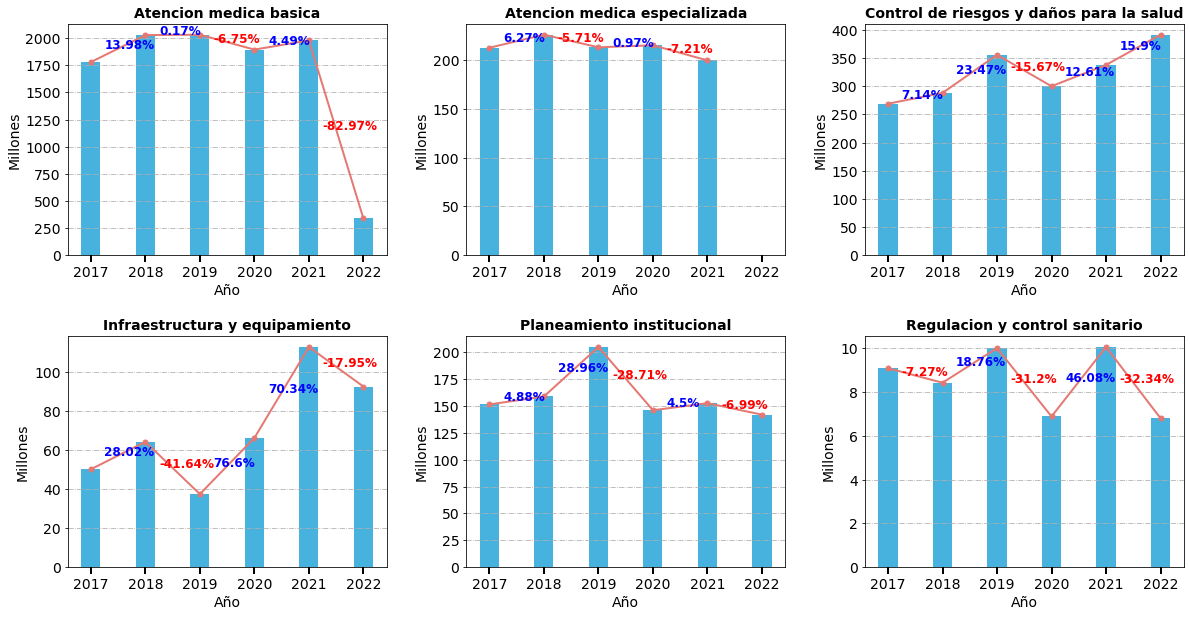

In [ ]:
me_final   = reduce(lambda  left,right: pd.merge(left,right, on = ['MES_EJE'], how = 'outer'), me_store)
## Falta pasarlo a real
me_final = me_final.tail(-1)
#me_final.plot()


gf_final   = reduce(lambda  left,right: pd.merge(left,right, on = ['GRUPO_FUNCIONAL_NOMBRE'], how = 'outer'), gf_store).T
gf_final.index = years_str

value = 1000000
for i_dfs in gf_final:
    gf_final[i_dfs] = ( ( np.divide(gf_final[i_dfs], cpi.cpi )*100 ) / value).round(2)


### EL grafico
gf_g = gf_final.copy()
### Graph
col_names = list(gf_g)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
plt.subplots_adjust(hspace=0.35, wspace = 0.25)

for i_colnames, ax in zip(np.arange(0,6), axs.ravel()):
    gf_g[col_names[i_colnames]].plot.bar(align='center', width=0.35,  color='#48b2de', ax=ax)
    gf_g[col_names[i_colnames]].plot.line(marker='o', linestyle='-', linewidth=2, markersize=5, color='#e57872', ax=ax )

    x_values_pc = pct_change_list( list(gf_g[col_names[i_colnames]]))

    for i, v in zip(np.arange(0,gf_g.shape[0]-1,1), mean_list(gf_g[col_names[i_colnames]])):

        if x_values_pc[i] > 0:
            ax.text(i + 0.25, v , str(round(x_values_pc[i],2)) + '%', color='blue', fontweight='bold',size=12)
        else:
            ax.text(i + 0.25, v , str(round(x_values_pc[i],2)) + '%', color='red', fontweight='bold', size=12)

    ax.set_xlabel('Año')
    ax.set_ylabel('Millones')
    ax.tick_params(axis='x', colors='black', labelrotation = 0 ,direction='out', length=7, width = 2)
    ax.set_title(col_names[i_colnames].capitalize(), fontweight ="bold");
    ax.yaxis.grid(ls='-.')

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

# #47b0aa , #48b2de , #e57872

fig.savefig('graph_grupo_funcional_real.pdf', bbox_inches = 'tight')
fig.savefig('graph_grupo_funcional_real.png', bbox_inches = 'tight')
plt.show()


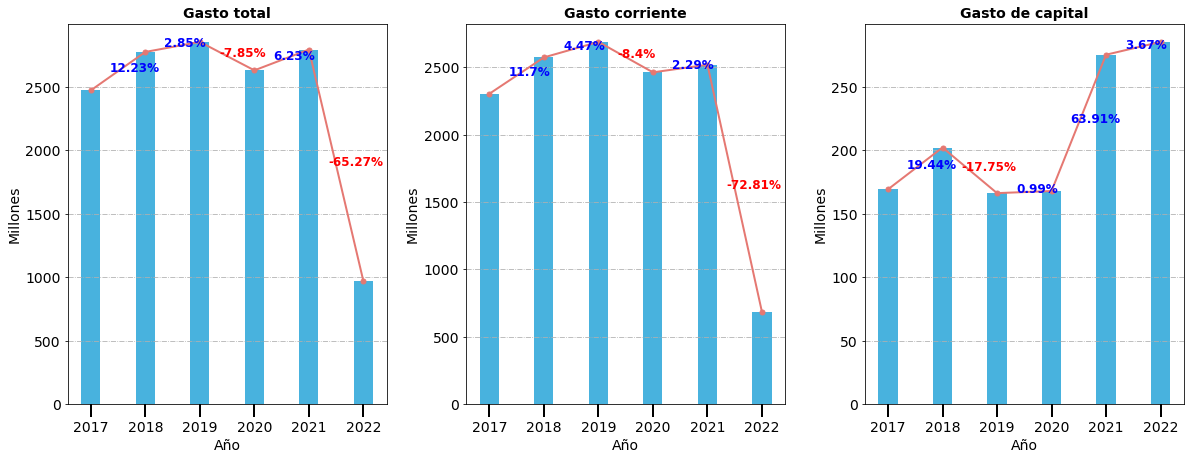

In [ ]:
cg_final   = reduce(lambda  left,right: pd.merge(left,right, on = ['CATEGORIA_GASTO_NOMBRE'], how = 'outer'), cg_store).T
cg_final['GASTO TOTAL'] = cg_final['GASTO CORRIENTE'] + cg_final['GASTO DE CAPITAL']
cg_final.index          = years_str
cg_final                = cg_final[['GASTO TOTAL','GASTO CORRIENTE','GASTO DE CAPITAL']]
for i_dfs in cg_final:
    cg_final[i_dfs] = ( ( np.divide(cg_final[i_dfs], cpi.cpi )*100 ) / value).round(2)

cg_g = cg_final.copy()

### Graph
col_names = list(cg_g)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
plt.subplots_adjust(hspace=0.35, wspace = 0.25)

for i_colnames, ax in zip(np.arange(0,3), axs.ravel()):
    cg_g[col_names[i_colnames]].plot.bar(align='center', width=0.35,  color='#48b2de', ax=ax)
    cg_g[col_names[i_colnames]].plot.line(marker='o', linestyle='-', linewidth=2, markersize=5, color='#e57872', ax=ax )

    x_values_pc = pct_change_list( list(cg_g[col_names[i_colnames]]))

    for i, v in zip(np.arange(0,gf_g.shape[0]-1,1), mean_list(cg_g[col_names[i_colnames]])):

        if x_values_pc[i] > 0:
            ax.text(i + 0.35, v , str(round(x_values_pc[i],2)) + '%', color='blue', fontweight='bold', size=12)
        else:
            ax.text(i + 0.35, v , str(round(x_values_pc[i],2)) + '%', color='red', fontweight='bold', size=12)


    ax.set_xlabel('Año')
    ax.set_ylabel('Millones')
    ax.tick_params(axis='x', colors='black',labelrotation = 0 ,direction='out', length=13, width = 2)
    ax.set_title(col_names[i_colnames].capitalize(), fontweight ="bold");
    ax.yaxis.grid(ls='-.')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

fig.savefig('graph_categoria_de_gasto_real.pdf', bbox_inches = 'tight')
fig.savefig('graph_categoria_de_gasto_real.png', bbox_inches = 'tight')
plt.show()